## Prepare

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import json
def load_data(filename='df_words.csv', lower = False, dupli=False) -> pd.DataFrame:
    df = pd.read_csv(filename)
    df = df.dropna()
    df_copy = df.copy()
    if lower:
      df_copy["Word"] = df_copy["Word"].str.lower()
    if dupli:
      df = pd.concat([df, df_copy])
    return df
df = load_data("trained_df_words.csv")
# df["Post_Content"] = df["Post_Content"].str.replace(",. ", ". ")
# df["Post_Content"] = df["Post_Content"].str.replace(". . ", ". ")
sentences = [sent for sent in df["Word"].str.split(r"\. ", expand=True).to_numpy().flatten() if sent != None]

agg = lambda s: [(w, t) for w, t in zip(s['Word'].values.tolist(),s['Tag'].values.tolist())]
# agg = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), s['POS'].values.tolist(),s['Tag'].values.tolist())]
grouped = df.groupby("Sentence_ID").apply(agg)
sentences = [s for s in grouped]

# Xây dựng vocab cho word và tag
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())

# Tạo dict word to index, thêm 2 từ đặc biệt là Unknown và Padding
# word2idx = {w : i + 2 for i, w in enumerate(words)}
# word2idx["UNK"] = 1
# word2idx["PAD"] = 0
with open("word2idx_v3.json", "r") as outfile:
    word2idx = json.load(outfile)
# Tạo dict tag to index, thêm 1 tag đặc biệt và Padding
# tag2idx = {t : i + 1 for i, t in enumerate(tags)}
# tag2idx["PAD"] = 0
with open("tag2idx_v3.json", "r") as outfile:
    tag2idx = json.load(outfile)
# Tạo 2 dict index to word và index to tag
idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [ ]:
# word2idx.update({w : i + 2 for i, w in enumerate(words)})
# words = list(word2idx.keys())
# words.remove("UNK")
# words.remove("PAD")
# for i, word in enumerate(words):
#   word2idx[word] = i + 2
# word2idx["UNK"] = 1
# word2idx["PAD"] = 0
# with open("word2idx_v3.json", "w") as outfile:
#     json.dump(word2idx, outfile)

In [ ]:
df.shape

(563395, 3)

In [ ]:
df[df["Tag"].isna()]

,Sentence_ID,Word,Tag


In [ ]:
# word2idx = {w : i + 2 for i, w in enumerate(words)}
# word2idx["UNK"] = 1
# word2idx["PAD"] = 0
# with open("word2idx.json", "w") as outfile:
#     json.dump(word2idx, outfile)
# tag2idx = {t : i + 1 for i, t in enumerate(tags)}
# tag2idx["PAD"] = 0
# with open("tag2idx.json", "w") as outfile:
#     json.dump(tag2idx, outfile)

In [ ]:
len(word2idx)

5808

In [ ]:
df['Tag'].unique()

array(['Outside', 'BItem', 'IItem', 'BAction', 'IAction', 'BSubject',
       'ISubject', 'BCurriculum-Components', 'ICurriculum-Components',
       'BPerson', 'IPerson', 'BEmotion', 'IEmotion'], dtype=object)

In [ ]:
print("Số lượng dữ liệu: ", df.shape[0])

Số lượng dữ liệu:  563395


In [ ]:
len(word2idx)

5808

In [ ]:
len(sentences)

41500

In [ ]:
import tensorflow as tf

# Chuyển các câu về dạng vector of index
X = [[word2idx[w[0]] for w in s] for s in sentences]
max_len = 187
# Padding các câu về max_len
X = tf.keras.utils.pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word2idx["PAD"])
# Chuyển các tag về dạng index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
max_len = 187
# Tiền hành padding về max_len
y = tf.keras.utils.pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag2idx["PAD"])

from keras.utils import to_categorical
num_tag = df['Tag'].nunique()
# y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
!pip install git+https://github.com/xuxingya/tf2crf.git

  Cloning https://github.com/xuxingya/tf2crf.git to /tmp/pip-req-build-vv7e8cqe
  Running command git clone --filter=blob:none --quiet https://github.com/xuxingya/tf2crf.git /tmp/pip-req-build-vv7e8cqe
  Resolved https://github.com/xuxingya/tf2crf.git to commit 348e63799f51ac59dae13fd5100f67ee620d5eaf
  Preparing metadata (setup.py) ... done
  Created wheel for tf2crf: filename=tf2crf-0.1.30-py2.py3-none-any.whl size=7358 sha256=3b8f3f3c973e476d0bca62826e78c2b26e641f0b731d2a8d309489a035426b33
  Stored in directory: /tmp/pip-ephem-wheel-cache-0c4bn42a/wheels/09/4a/69/b7b4dbba022d3b6ea278ba6eacc8c2fda3b91358c03c542b3d
Successfully built tf2crf


In [ ]:
X.shape

(41500, 187)

In [ ]:
!pip install graphviz
!pip install pydot

In [ ]:
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from keras.models import Model
from tf2crf import CRF, ModelWithCRFLoss

embedding = 128
hidden_size = 64
num_tags = df['Tag'].nunique()

input = Input(shape=(max_len,))
out = Embedding(input_dim=len(word2idx), output_dim=embedding, mask_zero=False)(input)
out = Bidirectional(LSTM(units=hidden_size, return_sequences=True, recurrent_dropout=0.1))(out)
out = TimeDistributed(Dense(hidden_size, activation="relu"))(out)
out = CRF(num_tags + 1)(out)  # CRF layer
# out = crf(model)  # output

base_model = Model(input, out)
model = ModelWithCRFLoss(base_model,  sparse_target=True)
model.compile(optimizer="rmsprop")
hist = model.fit(X_train, np.array(y_train), batch_size = 32, validation_split=0.2, epochs = 20)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Epoch 1/20
830/830 [==============================] - 470s 558ms/step - loss: 7.4665 - accuracy: 0.9890 - val_loss_val: 1.4561 - val_val_accuracy: 0.9977
Epoch 2/20
830/830 [==============================] - 456s 549ms/step - loss: 0.8468 - accuracy: 0.9986 - val_loss_val: 0.5321 - val_val_accuracy: 0.9990
Epoch 3/20
830/830 [==============================] - 455s 548ms/step - loss: 0.3164 - accuracy: 0.9994 - val_loss_val: 0.4446 - val_val_accuracy: 0.9994
Epoch 4/20
830/830 [==============================] - 460s 555ms/step - loss: 0.1484 - accuracy: 0.9997 - val_loss_val: 0.3139 - val_val_accuracy: 0.9997
Epoch 5/20
830/830 [==============================] - 454s 547ms/step - loss: 0.1051 - accuracy: 0.9998 - val_loss_val: 1.6362 - val_val_accuracy: 0.9998
Epoch 6/20
830/830 [==============================] - 462s 556ms/step - loss: 0.3136 - accuracy: 0.9999 - val_loss_val: 0.3622 - val_val_accuracy: 0.9998
Epoch 7/20
830/830 [==============================] - 460s 554ms/step - loss

KeyboardInterrupt: 

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss_val', 'val_val_accuracy'])

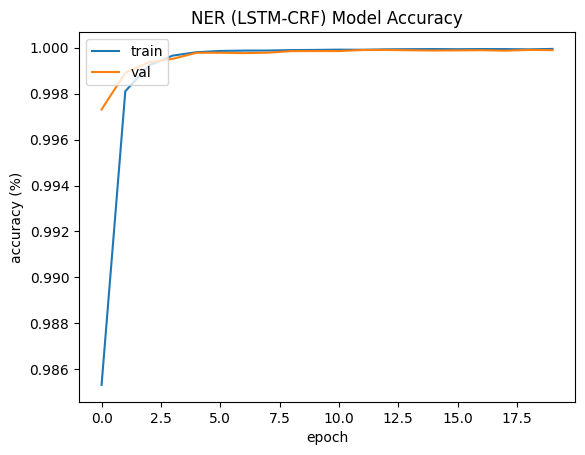

In [ ]:
import keras
from matplotlib import pyplot as plt
# history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_val_accuracy'])
plt.title('NER (LSTM-CRF) Model Accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

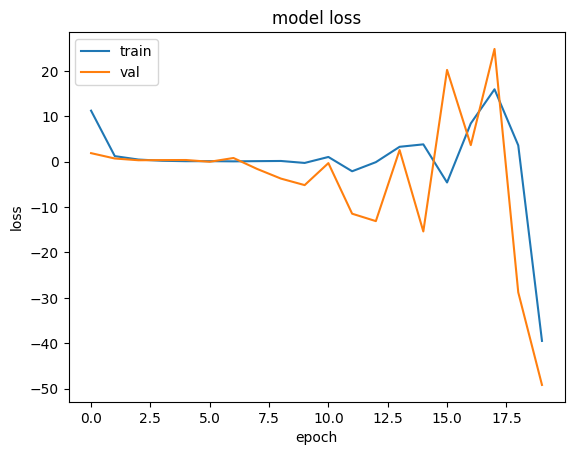

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss_val'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
X_test.shape

(8300, 187)

In [ ]:
i = 0
print(con(X_test[i]).split())
print(con2(result[i]).split())

NameError: name 'con' is not defined

In [ ]:
def con(Array):
  ls = []
  for i in Array:
    if idx2word[i] != "PAD":
      ls += [idx2word[i]]
  return " ".join(ls)
def con2(Array):
  ls = []
  for i in Array:
    if idx2tag[i] != "PAD":
      ls += [idx2tag[i]]
  return " ".join(ls)
result = model.predict(X_test)
count1, count2 = 0,0
for i, p, t in zip(X_test, y_test, result):
  a = con2(p).split()
  b = con2(t).split()
  count2 += len(a)
  for j,z in zip(a,b):
    if j == z:
      count1 += 1
print(count1, " / ", count2)
print(count1/count2)

260/260 [==============================] - 53s 185ms/step
115356  /  115540
0.9984074779297213


In [ ]:
model.save_weights("NER_v3.ckpt")

## implement

In [ ]:
import pandas as pd
import numpy as np
import json
def load_data(filename='df_words.csv') -> pd.DataFrame:
    df = pd.read_csv(filename)
    # df = df.dropna()
    return df
df = load_data()
# df["Post_Content"] = df["Post_Content"].str.replace(",. ", ". ")
# df["Post_Content"] = df["Post_Content"].str.replace(". . ", ". ")
sentences = [sent for sent in df["Word"].str.split(r"\. ", expand=True).to_numpy().flatten() if sent != None]

agg = lambda s: [(w, t) for w, t in zip(s['Word'].values.tolist(),s['Tag'].values.tolist())]
# agg = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), s['POS'].values.tolist(),s['Tag'].values.tolist())]
grouped = df.groupby("Sentence_ID").apply(agg)
sentences = [s for s in grouped]

# Xây dựng vocab cho word và tag
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())

# Tạo dict word to index, thêm 2 từ đặc biệt là Unknown và Padding
# word2idx = {w : i + 2 for i, w in enumerate(words)}
# word2idx["UNK"] = 1
# word2idx["PAD"] = 0
with open("word2idx_v3.json", "r") as outfile:
    word2idx = json.load(outfile)
# Tạo dict tag to index, thêm 1 tag đặc biệt và Padding
# tag2idx = {t : i + 1 for i, t in enumerate(tags)}
# tag2idx["PAD"] = 0
with open("tag2idx_v3.json", "r") as outfile:
    tag2idx = json.load(outfile)
# Tạo 2 dict index to word và index to tag
idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [ ]:
import tensorflow as tf

# Chuyển các câu về dạng vector of index
X = [[word2idx[w[0]] for w in s] for s in sentences]
max_len = 187
# Padding các câu về max_len
X = tf.keras.utils.pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word2idx["PAD"])

In [ ]:
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
# from keras.models import Model
# from tf2crf import CRF, ModelWithCRFLoss

# embedding = 128
# hidden_size = 64
# num_tags = df['Tag'].nunique()

# input = Input(shape=(max_len,))
# out = Embedding(input_dim=len(word2idx), output_dim=embedding, mask_zero=False)(input)
# out = Bidirectional(LSTM(units=hidden_size, return_sequences=True, recurrent_dropout=0.1))(out)
# out = TimeDistributed(Dense(hidden_size, activation="relu"))(out)
# out = CRF(num_tags + 1)(out)  # CRF layer
# # out = crf(model)  # output

# base_model = Model(input, out)
# model = ModelWithCRFLoss(base_model,  sparse_target=True)
# model.compile(optimizer="rmsprop")
# model.load_weights("NER.ckpt")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
result = model.predict(X)

490/490 [==============================] - 56s 114ms/step


In [ ]:
X.shape

(15660, 187)

In [ ]:
def con(Array):
  ls = []
  for i in Array:
    if idx2word[i] != "PAD":
      ls += [idx2word[i]]
  return " ".join(ls)
def con2(Array):
  ls = []
  for i in Array:
    if idx2tag[i] != "PAD":
      ls += [idx2tag[i]]
  return " ".join(ls)

In [ ]:
df_labeled = df.copy()

In [ ]:
Sentence_Id = df_labeled["Sentence_ID"].unique()
for i in range(result.shape[0]):
  tags = con2(result[i]).split()
  len_tag = df_labeled[df_labeled["Sentence_ID"] == Sentence_Id[i]].shape[0]
  # if i==311:
  #   print(tags, len_tag, con(X[i]))
  if len_tag > len(tags):
    tags += ["Outside"] * (len_tag-len(tags))
  else:
    tags = tags[:len_tag]
  index = df_labeled[df_labeled["Sentence_ID"] == Sentence_Id[i]].loc[:,"Tag"].index
  df_labeled.loc[index, "Tag"]= tags


In [ ]:
df_labeled.to_csv("NER.csv", encoding="utf-8", index=False)

In [ ]:
print(con(X[311]))
print(con2(result[311]).split())
print(len(con(X[311])))
print(len(con2(result[311]).split()))

Xin chào những bạn hữu duyên đã thấy được bài viết này
['Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside']
54
12


In [ ]:
print(con(X[15609]))
print(con2(result[15609]).split())

Các ca được sắp xếp phù hợp với thời khóa biểu sinh viên kinh tế dễ dàng sắp lịch học và đi làm
['Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'BItem', 'IItem', 'IItem', 'BTime', 'BTime', 'ITime', 'ISubject', 'Outside', 'Outside', 'Outside', 'BItem', 'IItem', 'Outside', 'Outside', 'Outside']


In [ ]:
df_labeled[df_labeled["Tag"].isna()]

,Sentence_ID,Word,Tag


## SBERT-CRF

In [ ]:
import pandas as pd
import numpy as np
import json
def load_data(filename='df_words.csv', lower = False, dupli=False) -> pd.DataFrame:
    df = pd.read_csv(filename)
    df = df.dropna()
    df_copy = df.copy()
    if lower:
      df_copy["Word"] = df_copy["Word"].str.lower()
    if dupli:
      df = pd.concat([df, df_copy])
    return df
df = load_data("trained_df_words.csv")
# df["Post_Content"] = df["Post_Content"].str.replace(",. ", ". ")
# df["Post_Content"] = df["Post_Content"].str.replace(". . ", ". ")
sentences = [sent for sent in df["Word"].str.split(r"\. ", expand=True).to_numpy().flatten() if sent != None]

agg = lambda s: [(w, t) for w, t in zip(s['Word'].values.tolist(),s['Tag'].values.tolist())]
# agg = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), s['POS'].values.tolist(),s['Tag'].values.tolist())]
grouped = df.groupby("Sentence_ID").apply(agg)
sentences = [s for s in grouped]

# Xây dựng vocab cho word và tag
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())

# Tạo dict word to index, thêm 2 từ đặc biệt là Unknown và Padding
# word2idx = {w : i + 2 for i, w in enumerate(words)}
# word2idx["UNK"] = 1
# word2idx["PAD"] = 0
with open("word2idx.json", "r") as outfile:
    word2idx = json.load(outfile)
# Tạo dict tag to index, thêm 1 tag đặc biệt và Padding
# tag2idx = {t : i + 1 for i, t in enumerate(tags)}
# tag2idx["PAD"] = 0
with open("tag2idx.json", "r") as outfile:
    tag2idx = json.load(outfile)
# Tạo 2 dict index to word và index to tag
idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [ ]:
X = [" ".join([w[0] for w in s]) for s in sentences]
X[1]

'Nhân ngày 8 3 , mình chúc các bạn luôn vui tươi , chúc cho thế giới này mãi xinh đẹp như các bạn'

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('keepitreal/vietnamese-sbert')
sentences_main = X
embeddings_main = model.encode(sentences_main)

In [ ]:
import tensorflow as tf

# Chuyển các tag về dạng index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
max_len = 187
# Tiền hành padding về max_len
y = tf.keras.utils.pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag2idx["PAD"])

In [ ]:
embeddings_main.shape, y.shape

((35915, 768), (35915, 187))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings_main, y, test_size = 0.15)

In [ ]:
base_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 dense_11 (Dense)            (None, 768, 64)           128       
                                                                 
 crf_5 (CRF)                 ((None, 768),             2136      
                              (None, 768, 24),                   
                              (None,),                           
                              (24, 24))                          
                                                                 
Total params: 2264 (8.84 KB)
Trainable params: 2264 (8.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
768%187

20

In [ ]:
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, Reshape, Flatten
from keras.models import Model
from tf2crf import CRF, ModelWithCRFLoss
from keras.callbacks import ModelCheckpoint
embedding = 768
hidden_size = 64
num_tags = df['Tag'].nunique()

input = Input(shape=(embedding,))
out = Dense(256, activation="relu")(input)
out = Dense(max_len, activation="relu")(input)
out = Reshape((max_len, 1))(out)
out = CRF(num_tags + 1)(out)  # CRF layer
# out = crf(model)  # output
filepath = "./model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_val_accuracy', verbose=1, save_best_only=True, mode='max')
base_model = Model(input, out)
model = ModelWithCRFLoss(base_model,  sparse_target=True)
model.compile(optimizer="rmsprop")
model.fit(X_train, np.array(y_train), batch_size = 32, validation_split=0.2, epochs = 10, callbacks=[checkpoint])

Epoch 1/10
764/764 [==============================] - ETA: 0s - loss: 288.0361 - accuracy: 0.9020
Epoch 1: val_val_accuracy improved from -inf to 0.94124, saving model to ./model.keras


764/764 [==============================] - 100s 125ms/step - loss: 288.0361 - accuracy: 0.9020 - val_loss_val: 61.3872 - val_val_accuracy: 0.9412
Epoch 2/10
764/764 [==============================] - ETA: 0s - loss: 27.1107 - accuracy: 0.9589
Epoch 2: val_val_accuracy improved from 0.94124 to 0.96612, saving model to ./model.keras


764/764 [==============================] - 109s 142ms/step - loss: 27.1107 - accuracy: 0.9589 - val_loss_val: 16.2179 - val_val_accuracy: 0.9661
Epoch 3/10
764/764 [==============================] - ETA: 0s - loss: 14.0665 - accuracy: 0.9701
Epoch 3: val_val_accuracy improved from 0.96612 to 0.97271, saving model to ./model.keras


764/764 [==============================] - 103s 135ms/step - loss: 14.0665 - accuracy: 0.9701 - val_loss_val: 12.6705 - val_val_accuracy: 0.9727
Epoch 4/10
764/764 [==============================] - ETA: 0s - loss: 11.7550 - accuracy: 0.9743
Epoch 4: val_val_accuracy improved from 0.97271 to 0.97509, saving model to ./model.keras


764/764 [==============================] - 108s 141ms/step - loss: 11.7550 - accuracy: 0.9743 - val_loss_val: 11.2057 - val_val_accuracy: 0.9751
Epoch 5/10
764/764 [==============================] - ETA: 0s - loss: 10.6994 - accuracy: 0.9759
Epoch 5: val_val_accuracy improved from 0.97509 to 0.97659, saving model to ./model.keras


764/764 [==============================] - 108s 141ms/step - loss: 10.6994 - accuracy: 0.9759 - val_loss_val: 10.4704 - val_val_accuracy: 0.9766
Epoch 6/10
764/764 [==============================] - ETA: 0s - loss: 10.1317 - accuracy: 0.9771
Epoch 6: val_val_accuracy improved from 0.97659 to 0.97720, saving model to ./model.keras


764/764 [==============================] - 106s 139ms/step - loss: 10.1317 - accuracy: 0.9771 - val_loss_val: 10.0580 - val_val_accuracy: 0.9772
Epoch 7/10
764/764 [==============================] - ETA: 0s - loss: 9.8071 - accuracy: 0.9775
Epoch 7: val_val_accuracy improved from 0.97720 to 0.97764, saving model to ./model.keras


764/764 [==============================] - 106s 139ms/step - loss: 9.8071 - accuracy: 0.9775 - val_loss_val: 9.8224 - val_val_accuracy: 0.9776
Epoch 8/10
764/764 [==============================] - ETA: 0s - loss: 9.5876 - accuracy: 0.9779
Epoch 8: val_val_accuracy improved from 0.97764 to 0.97767, saving model to ./model.keras


764/764 [==============================] - 107s 140ms/step - loss: 9.5876 - accuracy: 0.9779 - val_loss_val: 9.6468 - val_val_accuracy: 0.9777
Epoch 9/10
764/764 [==============================] - ETA: 0s - loss: 9.4276 - accuracy: 0.9781
Epoch 9: val_val_accuracy improved from 0.97767 to 0.97780, saving model to ./model.keras


764/764 [==============================] - 109s 142ms/step - loss: 9.4276 - accuracy: 0.9781 - val_loss_val: 9.5122 - val_val_accuracy: 0.9778
Epoch 10/10
764/764 [==============================] - ETA: 0s - loss: 9.3054 - accuracy: 0.9782
Epoch 10: val_val_accuracy improved from 0.97780 to 0.97809, saving model to ./model.keras


764/764 [==============================] - 106s 138ms/step - loss: 9.3054 - accuracy: 0.9782 - val_loss_val: 9.4254 - val_val_accuracy: 0.9781


In [ ]:
def con(Array):
  ls = []
  for i in Array:
    if idx2word[i] != "PAD":
      ls += [idx2word[i]]
  return " ".join(ls)
def con2(Array):
  ls = []
  for i in Array:
    if idx2tag[i] != "PAD":
      ls += [idx2tag[i]]
  return " ".join(ls)
result = model.predict(X_test)
count1, count2 = 0,0
for i, p, t in zip(X_test, y_test, result):
  a = con2(p).split()
  b = con2(t).split()
  count2 += len(a)
  for j,z in zip(a,b):
    if j == z:
      count1 += 1
print(count1, " / ", count2)
print(count1/count2)

169/169 [==============================] - 8s 43ms/step
41178  /  63365
0.6498540203582419


In [ ]:
y_test

array([[11, 12, 13, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       [11, 12, 12, ...,  0,  0,  0],
       ...,
       [ 6,  7, 11, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       [11, 12, 11, ...,  0,  0,  0]], dtype=int32)

In [ ]:
result

array([[11, 12, 12, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       [11, 12, 12, ...,  0,  0,  0],
       ...,
       [ 6,  7, 11, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       [11, 12,  0, ...,  0,  0,  0]], dtype=int32)